# Tutorial #21: Hypothesis Testing

In this tutorial you will generate some light curve data and use your hypothesis testing knowledge to try to determine if a signal is confidentally detected. 

You will come up with your own statistical test to do so, providing detailed explanations of your test and the results

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Part 1

The function below will be used to generate your data

In [2]:
# Execute this cell

np.random.seed(100)

def generate_arrival_times(true_sig_rate, signal_tstart=0.0, signal_tstop=1.0, true_bkg_rate=100.0, tstart=0.0, tstop=100.0):

    tot_exp = (tstop - tstart)
    Nbkg_tot = np.random.poisson(true_bkg_rate*tot_exp)
    print('Nbkg_tot =', Nbkg_tot)

    bkg_arrival_times = np.random.uniform(low=tstart, high=tstop, size=Nbkg_tot)

    if true_sig_rate > 0:
        tot_sig_duration = signal_tstop - signal_tstart
        Nsig_tot = np.random.poisson(true_sig_rate*1)
        print('Nsig_tot =', Nsig_tot)


        sig_arrival_times = np.random.uniform(low=signal_tstart, high=signal_tstop, size=Nsig_tot)

        arrival_times = np.append(bkg_arrival_times, sig_arrival_times)

        return arrival_times #<<< Added this line  b.c. the function was returning None at the end

    else:
        return bkg_arrival_times



Generate the data by putting in the correct input arguments

In [3]:
signal_tstart = 50.0
signal_tstop = 51.0
true_sig_rate = 80.0

arrival_times = generate_arrival_times(true_sig_rate, signal_tstart, signal_tstop)

Nbkg_tot = 10012
Nsig_tot = 69


Create a light curve, by making a histogram of the arrival times. 

Make bins that range from 0 to 100 with a step size of 1

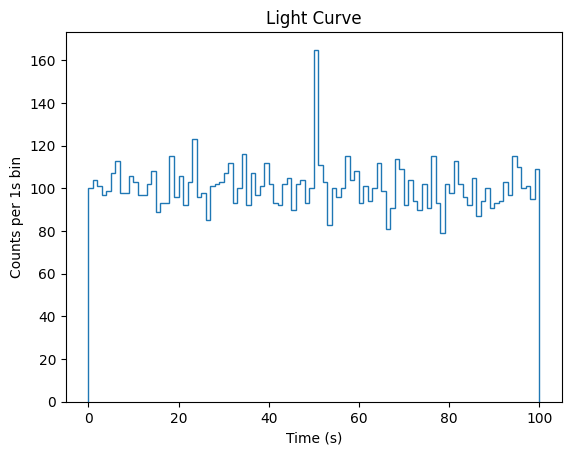

In [4]:
tstart = 0
tstop = 100
# Create a histogram (light curve)
bins = np.arange(tstart, tstop+1, 1)  # 1-second bins from 0 to 100 s
LC = plt.hist(arrival_times, bins=bins, histtype='step')[0]

# Label axes
plt.xlabel('Time (s)')
plt.ylabel('Counts per 1s bin')
plt.title('Light Curve')
plt.show()


You are interested specificially in if there is a signal above background between t = 50 s and t = 51 s. 

Everything outisde of t = 50 - 51 s can be assumed to be background only and the background properties can be derived from there. The LC you just made is your data. 

Devise a statistical test that could answer your question

Throughly describe your test, including details about
- What is your test statistic?
- What are your hypotheses? 
- What are the possible conclusions of your test (before running the test)
- How will you assess the significance of your test statistic? 
- What is your threshold for different conlusions? 

### 1. **Test Statistic**:

My test statistic will be the z-score of the signal count with respect to the bkg count.
Test statistic:

$$Z = \frac{N_{\text{obs}} - N_{\text{bkg}}}{\sqrt{N_{\text{bkg}}}}$$

where:

$𝑁_{obs}$ = observed counts between 50–51 s

$𝑁_{bkg}$ = expected background counts between 50–51 s, estimated from counts outside 50–51 s (background-only region)

---

### 2. **Hypotheses**

We want to know if there’s a statistically significant signal *above background* between \( t = 50 \) and \( t = 51 \) seconds.

- **Null Hypothesis ($H_0$)**:  
  The counts between 50 and 51 s are consistent with background-only fluctuations.  
  (*No real signal, only background noise.*)

- **Alternative Hypothesis ($H_1$)**:  
  There is an excess of counts between 50 and 51 s that cannot be explained by background alone.  
  (*A real signal is present.*)

---

### 3. **How to Estimate Background \($N_{\text{bkg}}$\)**

- Measure total counts outside of [50, 51] s.
- Compute the **background rate**:

$$
\text{rate}_{\text{bkg}} = \frac{N_{\text{bkg outside}}}{T_{\text{outside}}}
$$

- Expected background counts in [50, 51] s:

$$
N_{\text{bkg}} = \text{rate}_{\text{bkg}} \times (51-50)
= \text{rate}_{\text{bkg}} \times 1 \text{ s}
$$

---

### 4. **Possible Conclusions**

- **If \(Z\) is small (near 0)**:  
  No significant signal → **fail to reject** \(H_0\) (no detection).
  
- **If \(Z\) is large (positive)**:  
  Significant excess → **reject** \(H_0\) and it is likely there **is a signal**.

---

### 5. **Significance & Threshold**

Assume \(Z\) follows a standard normal distribution (because for large counts, Poisson \(\approx\) Normal).

Thresholds:

- \( Z > 3 \): ~3σ detection (99.7% confidence)
- \( Z > 5 \): ~5σ detection (gold standard for discovery in physics)

Typical rules for conclusions:

- \( Z < 2 \): No signal, fail to reject \(H_0\)
- \( 2 \leq Z < 3 \): Weak evidence for signal
- \( Z \geq 3 \): Significant detection
- \( Z \geq 5 \): Very strong detection

---

Execute your test on the data and describe your conclusion

In [5]:
# Count events in the signal region [50, 51) s
signal_bin = int(signal_tstart)  # 50th bin

N_obs = LC[signal_bin]
print(f"Observed counts in [50, 51) s: {N_obs}")


Observed counts in [50, 51) s: 165.0


Total background counts: 9916, Total background time: 99.0 s
Estimated background rate: 100.16 counts/s
Expected background counts in [50, 51) s: 100.16


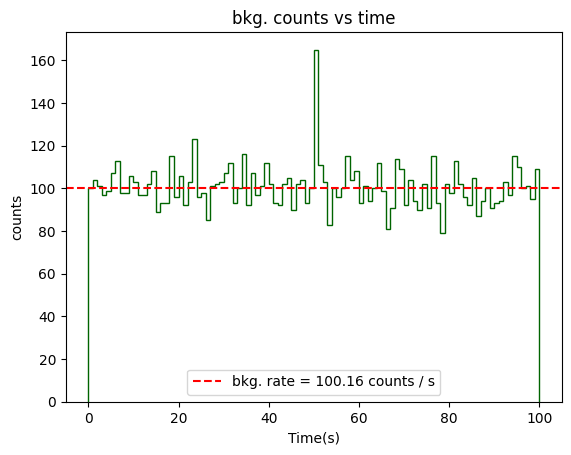

In [6]:
# Mask out the signal bin to get background-only bins
bkg_bins = [(arrival_times < signal_tstart) | (arrival_times > signal_tstop)]

# Total number of background counts
N_bkg_total = np.sum(bkg_bins)

# Total time of background-only regions
T_bkg = 100.0 - 1.0  # total 100 seconds minus 1 second of signal region
print(f"Total background counts: {N_bkg_total}, Total background time: {T_bkg} s")

# Background rate (counts per second)
rate_bkg = N_bkg_total / T_bkg
print(f"Estimated background rate: {rate_bkg:.2f} counts/s")

# Expected background counts in the signal window (1 second)
N_bkg_expected = rate_bkg * 1.0
print(f"Expected background counts in [50, 51) s: {N_bkg_expected:.2f}")


plt.hist(arrival_times, bins=bins, histtype='step', color='darkgreen') #bkg count plot
plt.xlabel('Time(s)')
plt.ylabel('counts')
plt.title('bkg. counts vs time')
plt.axhline(y=rate_bkg, color='r', linestyle='--', label=f'bkg. rate = {rate_bkg:.2f} counts / s')
plt.legend()
plt.show()


Signal Z-score: 6.478605260803532
P-value: 4.629e-11


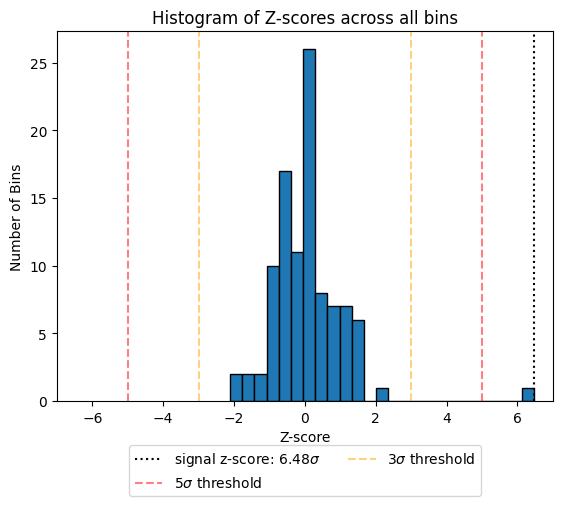

In [7]:
from scipy.stats import norm # To calculate the p-value of out result


Z_scores = (LC - N_bkg_expected) / np.sqrt(N_bkg_expected)

Z_sig = Z_scores[signal_bin]
print("Signal Z-score:", Z_sig)
p_val = 1 - norm.cdf(Z_sig)
print(f"P-value: {p_val:.3e}")

# Plot histogram of Z-scores
plt.hist(Z_scores, bins=25, edgecolor='black')
plt.xlim(-7, 7)
plt.xlabel('Z-score')
plt.ylabel('Number of Bins')
plt.title('Histogram of Z-scores across all bins')

# Signal z-score line
plt.axvline(Z_sig, color='black', linestyle=':', label=f'signal z-score: {Z_sig:.2f}$\sigma$')

# Positive thresholds
plt.axvline(5, color='red', linestyle='--', alpha = 0.5, label='5$\sigma$ threshold')
plt.axvline(3, color='orange', linestyle='--', alpha = 0.5, label='3$\sigma$ threshold')

# Negative thresholds
plt.axvline(-5, color='red', linestyle='--', alpha = 0.5)
plt.axvline(-3, color='orange', linestyle='--', alpha = 0.5)

# Legend
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)
plt.show()

### Conclusion

The histogram of Z-scores across all bins shows that the vast majority of background fluctuations are centered around zero, as expected for background noise. Most bins fall within the ±2σ range, with progressively fewer bins extending into the ±3σ and ±5σ regions. 

The signal bin has a Z-score of **6.48σ**, which is well beyond the **5σ discovery threshold**. This strongly suggests that the observed signal is very statistically significant and not a random background fluctuation.

Our P-val of ~4.63e-11 means that if the Null Hypothesis were true there is a ~4.63e-9 **( 0.000000004629 % )** chance of getting this result by pure chance.

Thus, based on this analysis, we can confidently conclude that there is compelling evidence for a real signal in the data.


___

### Part 2

Now let's do a similar but different test. This time let's do a search. 

Now we are not just interested if there is a signal at a specific time, we want to test if there is a signal at any time in the data, and not only at a 1 s interval. 

Like in Part 1, you are to devise a statistical test to try to determine if there is a signal above the background present somewhere in the data. 

Not like in Part 1, this time your looking at more than one observation so think carefully about what your actual test statistic will be. 
- For the entire search, there should be a single test statistic 

The search should take the arrival times and make three different light curves, one with 0.1 s bins, one with 0.25 s bins, and another with 1 s bins. 

Hint: To test if there is a signal somewhere in these 3 light curves, it may make sense to look for the "strongest" signal 

It's likely that your test statistic will no longer have a simple distribution (under the null hypothesis). 

If that is the case you can do many background-only experiments to build your own distribution of your test statistic 

To do a background-only experiment
- resimulate the data but only the bkg events
- run your search
- record your test statistic 

To build your test statistic distribution, repeat this process many times. A density histogram of this can work just like the PDF of a known statistical distribution. 

Write a function that performs your search. 

It should 
- take an array of arrival times
- create the 3 LCs 
- calculate and return your test statistic 

In [8]:
def search_for_signal(arrival_times, tstart=0.0, tstop=100.0):
    """
    Function to search for signals in the data by creating light curves
    with different bin sizes and finding the maximum Z-score.
    
    Args:
        arrival_times: Array of event arrival times
        tstart: Start time of observation
        tstop: End time of observation
        
    Returns:
        max_zscore: The maximum Z-score found across all light curves
    """
    # Define bin sizes
    bin_sizes = [0.1, 0.25, 1.0]
    
    # Track the maximum Z-score
    max_zscore = 0
    
    # Loop through each bin size
    for bin_size in bin_sizes:
        # Create bins for this bin size
        bins = np.arange(tstart, tstop + bin_size, bin_size)
        
        # Create histogram (light curve)
        counts, _ = np.histogram(arrival_times, bins=bins)
        
        # Calculate background rate from all bins
        total_counts = np.sum(counts)
        total_time = tstop - tstart
        bkg_rate = total_counts / total_time
        
        # Expected counts in each bin
        expected_counts = bkg_rate * bin_size
        
        # Calculate Z-scores for each bin
        z_scores = (counts - expected_counts) / np.sqrt(expected_counts)
        
        # Find maximum Z-score
        bin_max_zscore = np.max(z_scores)
        
        # Update max Z-score if this one is higher
        if bin_max_zscore > max_zscore:
            max_zscore = bin_max_zscore
    
    return max_zscore

Generate many trials of background-only data and perform the search on each set of data to build null test statistic distribution

For each trial,
- generate data
- run the search
- add the test statistic to an array or list

In [9]:
# Number of trials for background-only simulation
n_trials = 10000
TS_values = []

# Generate many trials of background-only data
for i in range(n_trials):
    # Generate background-only data (signal rate = 0)
    bg_arrival_times = generate_arrival_times(true_sig_rate=0.0, 
                                             true_bkg_rate=100.0, 
                                             tstart=0.0, 
                                             tstop=100.0)
    
    # Run the search on this data
    ts = search_for_signal(bg_arrival_times)
    
    # Add test statistic to our collection
    TS_values.append(ts)
    
    # Print progress every 1000 trials
    if (i+1) % 1000 == 0:
        print(f"Completed {i+1} trials")

# Convert to numpy array
TS_values = np.array(TS_values)

Nbkg_tot = 9986
Nbkg_tot = 9883
Nbkg_tot = 10009
Nbkg_tot = 10131
Nbkg_tot = 10047
Nbkg_tot = 10013
Nbkg_tot = 9984
Nbkg_tot = 10036
Nbkg_tot = 9895
Nbkg_tot = 9995
Nbkg_tot = 10015
Nbkg_tot = 9973
Nbkg_tot = 10049
Nbkg_tot = 10033
Nbkg_tot = 9978
Nbkg_tot = 10137
Nbkg_tot = 9870
Nbkg_tot = 9876
Nbkg_tot = 10090
Nbkg_tot = 10005
Nbkg_tot = 10038
Nbkg_tot = 10027
Nbkg_tot = 9978
Nbkg_tot = 10176
Nbkg_tot = 10028
Nbkg_tot = 9899
Nbkg_tot = 10088
Nbkg_tot = 9931
Nbkg_tot = 10033
Nbkg_tot = 10001
Nbkg_tot = 10121
Nbkg_tot = 9826
Nbkg_tot = 10118
Nbkg_tot = 9993
Nbkg_tot = 9870
Nbkg_tot = 9896
Nbkg_tot = 9885
Nbkg_tot = 10028
Nbkg_tot = 9858
Nbkg_tot = 9927
Nbkg_tot = 9986
Nbkg_tot = 9965
Nbkg_tot = 9872
Nbkg_tot = 10050
Nbkg_tot = 10041
Nbkg_tot = 9936
Nbkg_tot = 9976
Nbkg_tot = 10051
Nbkg_tot = 9914
Nbkg_tot = 10042
Nbkg_tot = 9835
Nbkg_tot = 9977
Nbkg_tot = 10008
Nbkg_tot = 10140
Nbkg_tot = 10008
Nbkg_tot = 9931
Nbkg_tot = 9903
Nbkg_tot = 9819
Nbkg_tot = 9914
Nbkg_tot = 9862
Nbkg_tot = 1

Plot a density histogram of your test statistic values

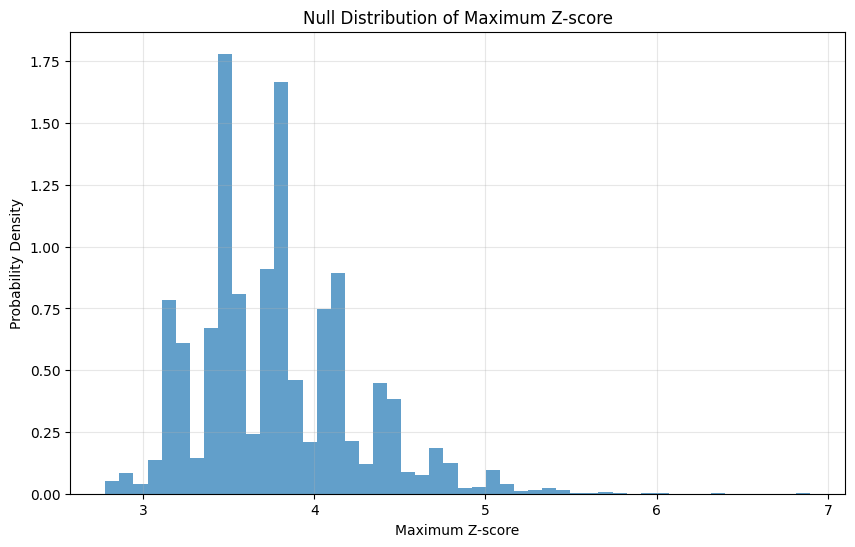

In [10]:
plt.figure(figsize=(10, 6))
plt.hist(TS_values, bins=50, density=True, alpha=0.7)
plt.xlabel('Maximum Z-score')
plt.ylabel('Probability Density')
plt.title('Null Distribution of Maximum Z-score')
plt.grid(alpha=0.3)
plt.show()

Plot the survival function of your test statistic distribution 

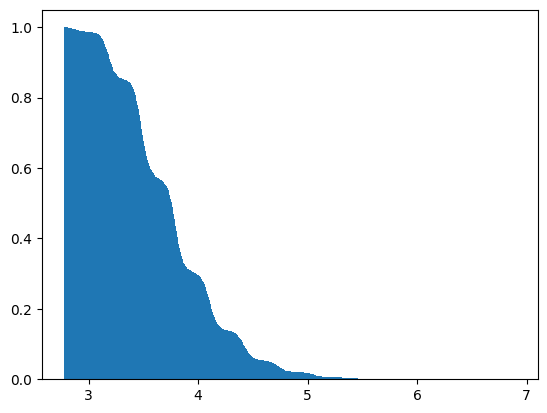

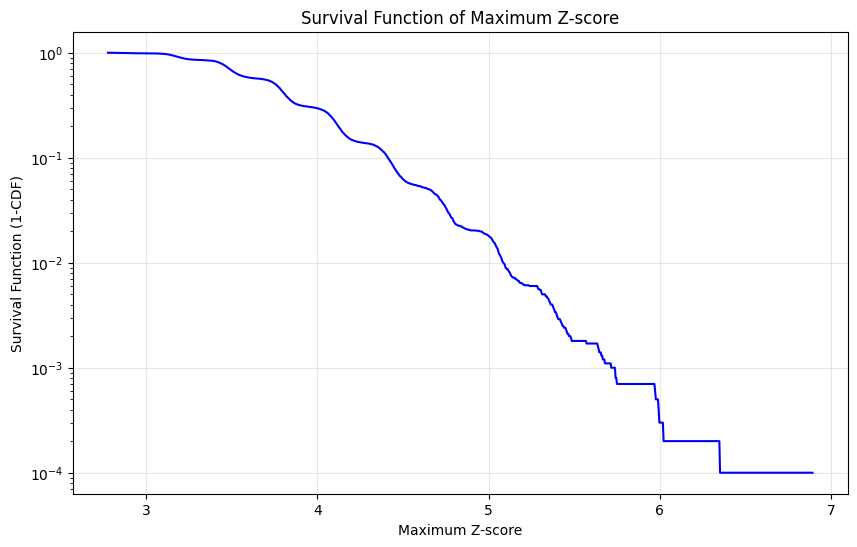

In [11]:
# Make many small bins
# Fill with min and max values of the test statistic
bins = np.linspace(np.min(TS_values), np.max(TS_values), 1000)

# Cumulative means to add each successive bin
# Setting it to -1 means to do this in the opposite direction
ts_sf = plt.hist(TS_values, bins=bins, cumulative=-1, density=True)[0]

# Plot the survival function
plt.figure(figsize=(10, 6))
plt.semilogy(bins[:-1], ts_sf, 'b-')
plt.xlabel('Maximum Z-score')
plt.ylabel('Survival Function (1-CDF)')
plt.title('Survival Function of Maximum Z-score')
plt.grid(alpha=0.3)
plt.show()  

The survival function gives you the probability in the tail of your distribution at >=x

Generate a set of arrival times with the same background rate, but also include signal like we did in Part 1. 

Use 
- true_sig_rate = 50.0
- signal_tstart = 50.0
- signal_tstop = 51.0

Nbkg_tot = 10082
Nsig_tot = 54
Test statistic for data with signal (1s duration): 4.334624096915758
P-value: 0.1312


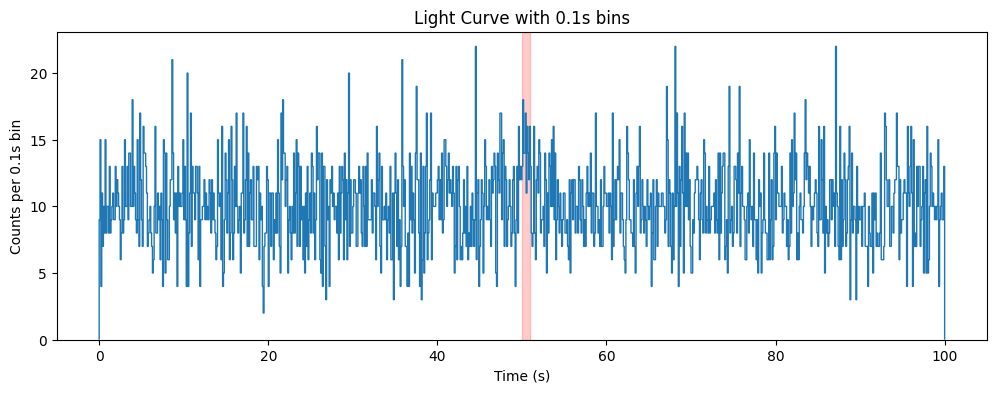

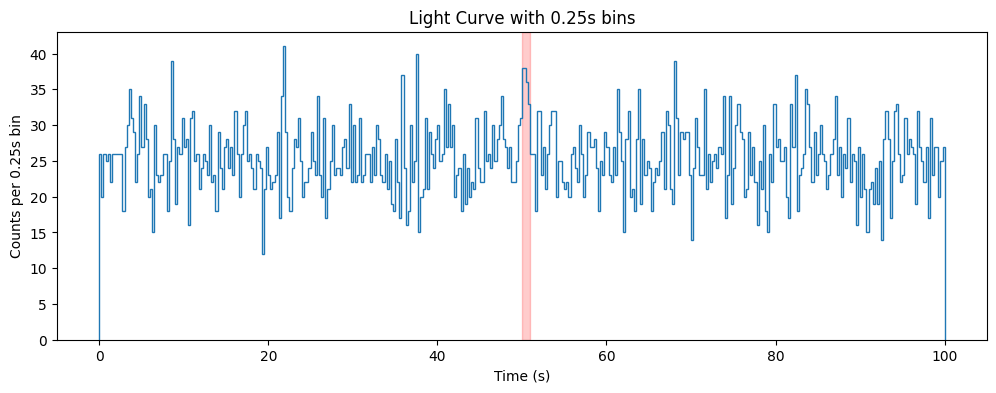

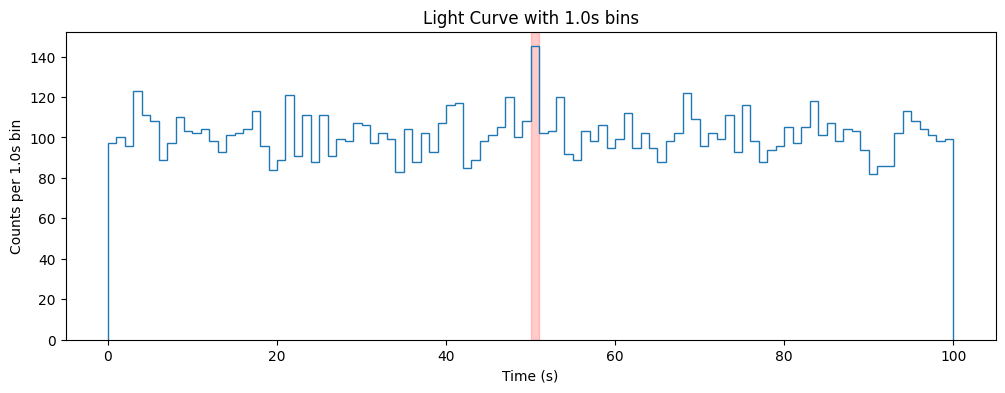

In [12]:
# Generate data with signal
true_sig_rate = 50.0
signal_tstart = 50.0
signal_tstop = 51.0

# Generate arrival times with signal
arrival_times_with_signal = generate_arrival_times(true_sig_rate=true_sig_rate,
                                                  signal_tstart=signal_tstart,
                                                  signal_tstop=signal_tstop,
                                                  true_bkg_rate=100.0,
                                                  tstart=0.0,
                                                  tstop=100.0)

# Run search on the data with signal
ts_signal = search_for_signal(arrival_times_with_signal)
print(f"Test statistic for data with signal (1s duration): {ts_signal}")

# Calculate p-value (probability of observing this test statistic or higher under the null hypothesis)
p_value = np.sum(TS_values >= ts_signal) / len(TS_values)
print(f"P-value: {p_value}")

# If p-value is 0, we need to be more precise
if p_value == 0:
    p_value = f"< {1/len(TS_values)}"
    print(f"More precise p-value: {p_value}")

# Plot the light curves for visual inspection
for bin_size in [0.1, 0.25, 1.0]:
    bins = np.arange(0, 100 + bin_size, bin_size)
    plt.figure(figsize=(12, 4))
    plt.hist(arrival_times_with_signal, bins=bins, histtype='step')
    plt.xlabel('Time (s)')
    plt.ylabel(f'Counts per {bin_size}s bin')
    plt.title(f'Light Curve with {bin_size}s bins')
    plt.axvspan(signal_tstart, signal_tstop, alpha=0.2, color='red')
    plt.show()

Run your search on the data and peform your test. 

State your conclusion 

***The test statistic has a value of 4.33 and we have a p-value 0f ~0.13. This means there is ~a 13% chance this is not a sinal and just backgroudn noise; This p-value is not smaller than 0.05 (95% confidence) or 0.01 (99% confidence).***

Repeat this with a different signal 

Generate a set of arrival times with the same background rate, but also include signal like we did in Part 1. 

Use 
- true_sig_rate = 50.0
- signal_tstart = 50.0
- signal_tstop = 50.1

Nbkg_tot = 9878
Nsig_tot = 39
Test statistic for data with short signal (0.1s duration): 12.093193337506682
P-value: 0.0
More precise p-value: < 0.0001


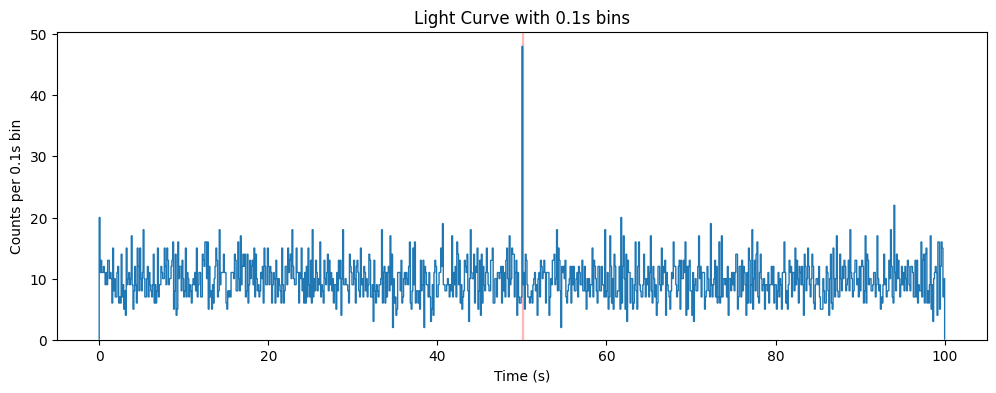

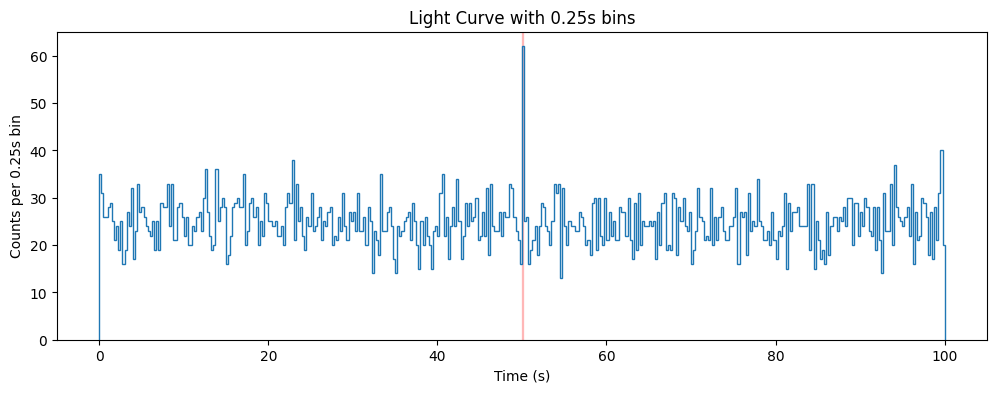

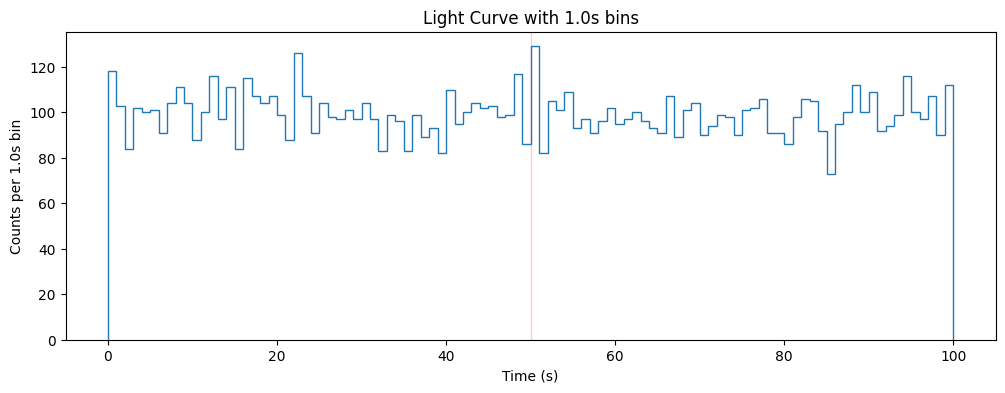

In [13]:
# Generate data with shorter signal
true_sig_rate = 50.0
signal_tstart = 50.0
signal_tstop = 50.1

# Generate arrival times with signal
arrival_times_with_short_signal = generate_arrival_times(true_sig_rate=true_sig_rate,
                                                        signal_tstart=signal_tstart,
                                                        signal_tstop=signal_tstop,
                                                        true_bkg_rate=100.0,
                                                        tstart=0.0,
                                                        tstop=100.0)

# Run search on the data with signal
ts_short_signal = search_for_signal(arrival_times_with_short_signal)
print(f"Test statistic for data with short signal (0.1s duration): {ts_short_signal}")

# Calculate p-value
p_value_short = np.sum(TS_values >= ts_short_signal) / len(TS_values)
print(f"P-value: {p_value_short}")

# If p-value is 0, we need to be more precise
if p_value_short == 0:
    p_value_short = f"< {1/len(TS_values)}"
    print(f"More precise p-value: {p_value_short}")

# Plot the light curves for visual inspection
for bin_size in [0.1, 0.25, 1.0]:
    bins = np.arange(0, 100 + bin_size, bin_size)
    plt.figure(figsize=(12, 4))
    plt.hist(arrival_times_with_short_signal, bins=bins, histtype='step')
    plt.xlabel('Time (s)')
    plt.ylabel(f'Counts per {bin_size}s bin')
    plt.title(f'Light Curve with {bin_size}s bins')
    plt.axvspan(signal_tstart, signal_tstop, alpha=0.2, color='red')
    plt.show()

Run your search on the data and peform your test. 

State your conclusion 

***This test statistics has value of 12.09 and a p-value < 0.0001 making this extremely unlikely to be random noise. We can say with over 99.999% confidence that this is a real signal.***